In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import mstats
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,accuracy_score, precision_score,roc_auc_score,f1_score,confusion_matrix

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.family'] = 'Malgun Gothic'

import warnings
warnings.filterwarnings('ignore')


## 0.파일 불러오기

In [2]:
df = pd.read_csv('../data/processed_data/재무비율_재무지표_concat.csv', index_col=0)
df.head()

,회사명,거래소코드,회계년도,소속코드_df1,통계청 한국표준산업분류 코드 10차(대분류)_df1,산업코드_df1,산업명_df1,상장일_df1,상장폐지일_df1,현금및현금성자산(IFRS),...,자본분배율(IFRS),이윤분배율(IFRS),법인세비용차감전(계속사업)손익(IFRS)(백만원),인건비(IFRS)(백만원),금융비용(IFRS)(백만원),임차료(IFRS)(백만원),세금과공과(IFRS)(백만원),감가상각비(IFRS)(백만원),종업원수(IFRS),label_df2
0,(주)다이나믹디자인,145210,2015,1,29,32902,기타 기계 및 장비 제조업,2015-03-19,0,10376890.0,...,29.18,2.06,1548.77,46876.84,3589.40,0.0,0.0,14203.75,150.0,1
1,(주)다이나믹디자인,145210,2016,1,29,32902,기타 기계 및 장비 제조업,2015-03-19,0,15192647.0,...,0.00,0.00,-11379.61,0.00,0.00,0.0,0.0,0.00,134.0,1
2,(주)다이나믹디자인,145210,2017,1,29,32902,기타 기계 및 장비 제조업,2015-03-19,0,6564156.0,...,-90.09,-161.93,-34429.26,39598.55,3990.88,0.0,0.0,11694.91,526.0,1
3,(주)대우건설,47040,2012,1,41,64101,종합 건설업,2001-03-23,0,388440274.0,...,40.72,12.78,227947.72,802635.00,94086.89,124047.0,54145.0,51212.00,5192.0,0
4,(주)대우건설,47040,2013,1,41,64101,종합 건설업,2001-03-23,0,409596263.0,...,-125.45,-177.13,-839724.66,913926.00,86015.38,123239.0,62921.0,59003.00,6382.0,0


In [3]:
X_data = df[df.columns[9:-1]]
y_data = df['label_df2']

## 윈저라이징 이전 데이터 확인

In [4]:
before_winsor_feature = X_data.copy()

In [5]:
X_data.columns

Index(['현금및현금성자산(IFRS)', '유동금융자산(IFRS)', '매출채권 및 기타유동채권(IFRS)',
       '상각후원가측정 유가증권(IFRS)', '매출채권(IFRS)', '미수금(IFRS)', '단기대여금(IFRS)',
       '선급금(IFRS)', '기타유동자산(IFRS)', '상품(IFRS)',
       ...
       '노동소득분배율(IFRS)', '자본분배율(IFRS)', '이윤분배율(IFRS)',
       '법인세비용차감전(계속사업)손익(IFRS)(백만원)', '인건비(IFRS)(백만원)', '금융비용(IFRS)(백만원)',
       '임차료(IFRS)(백만원)', '세금과공과(IFRS)(백만원)', '감가상각비(IFRS)(백만원)', '종업원수(IFRS)'],
      dtype='object', length=194)

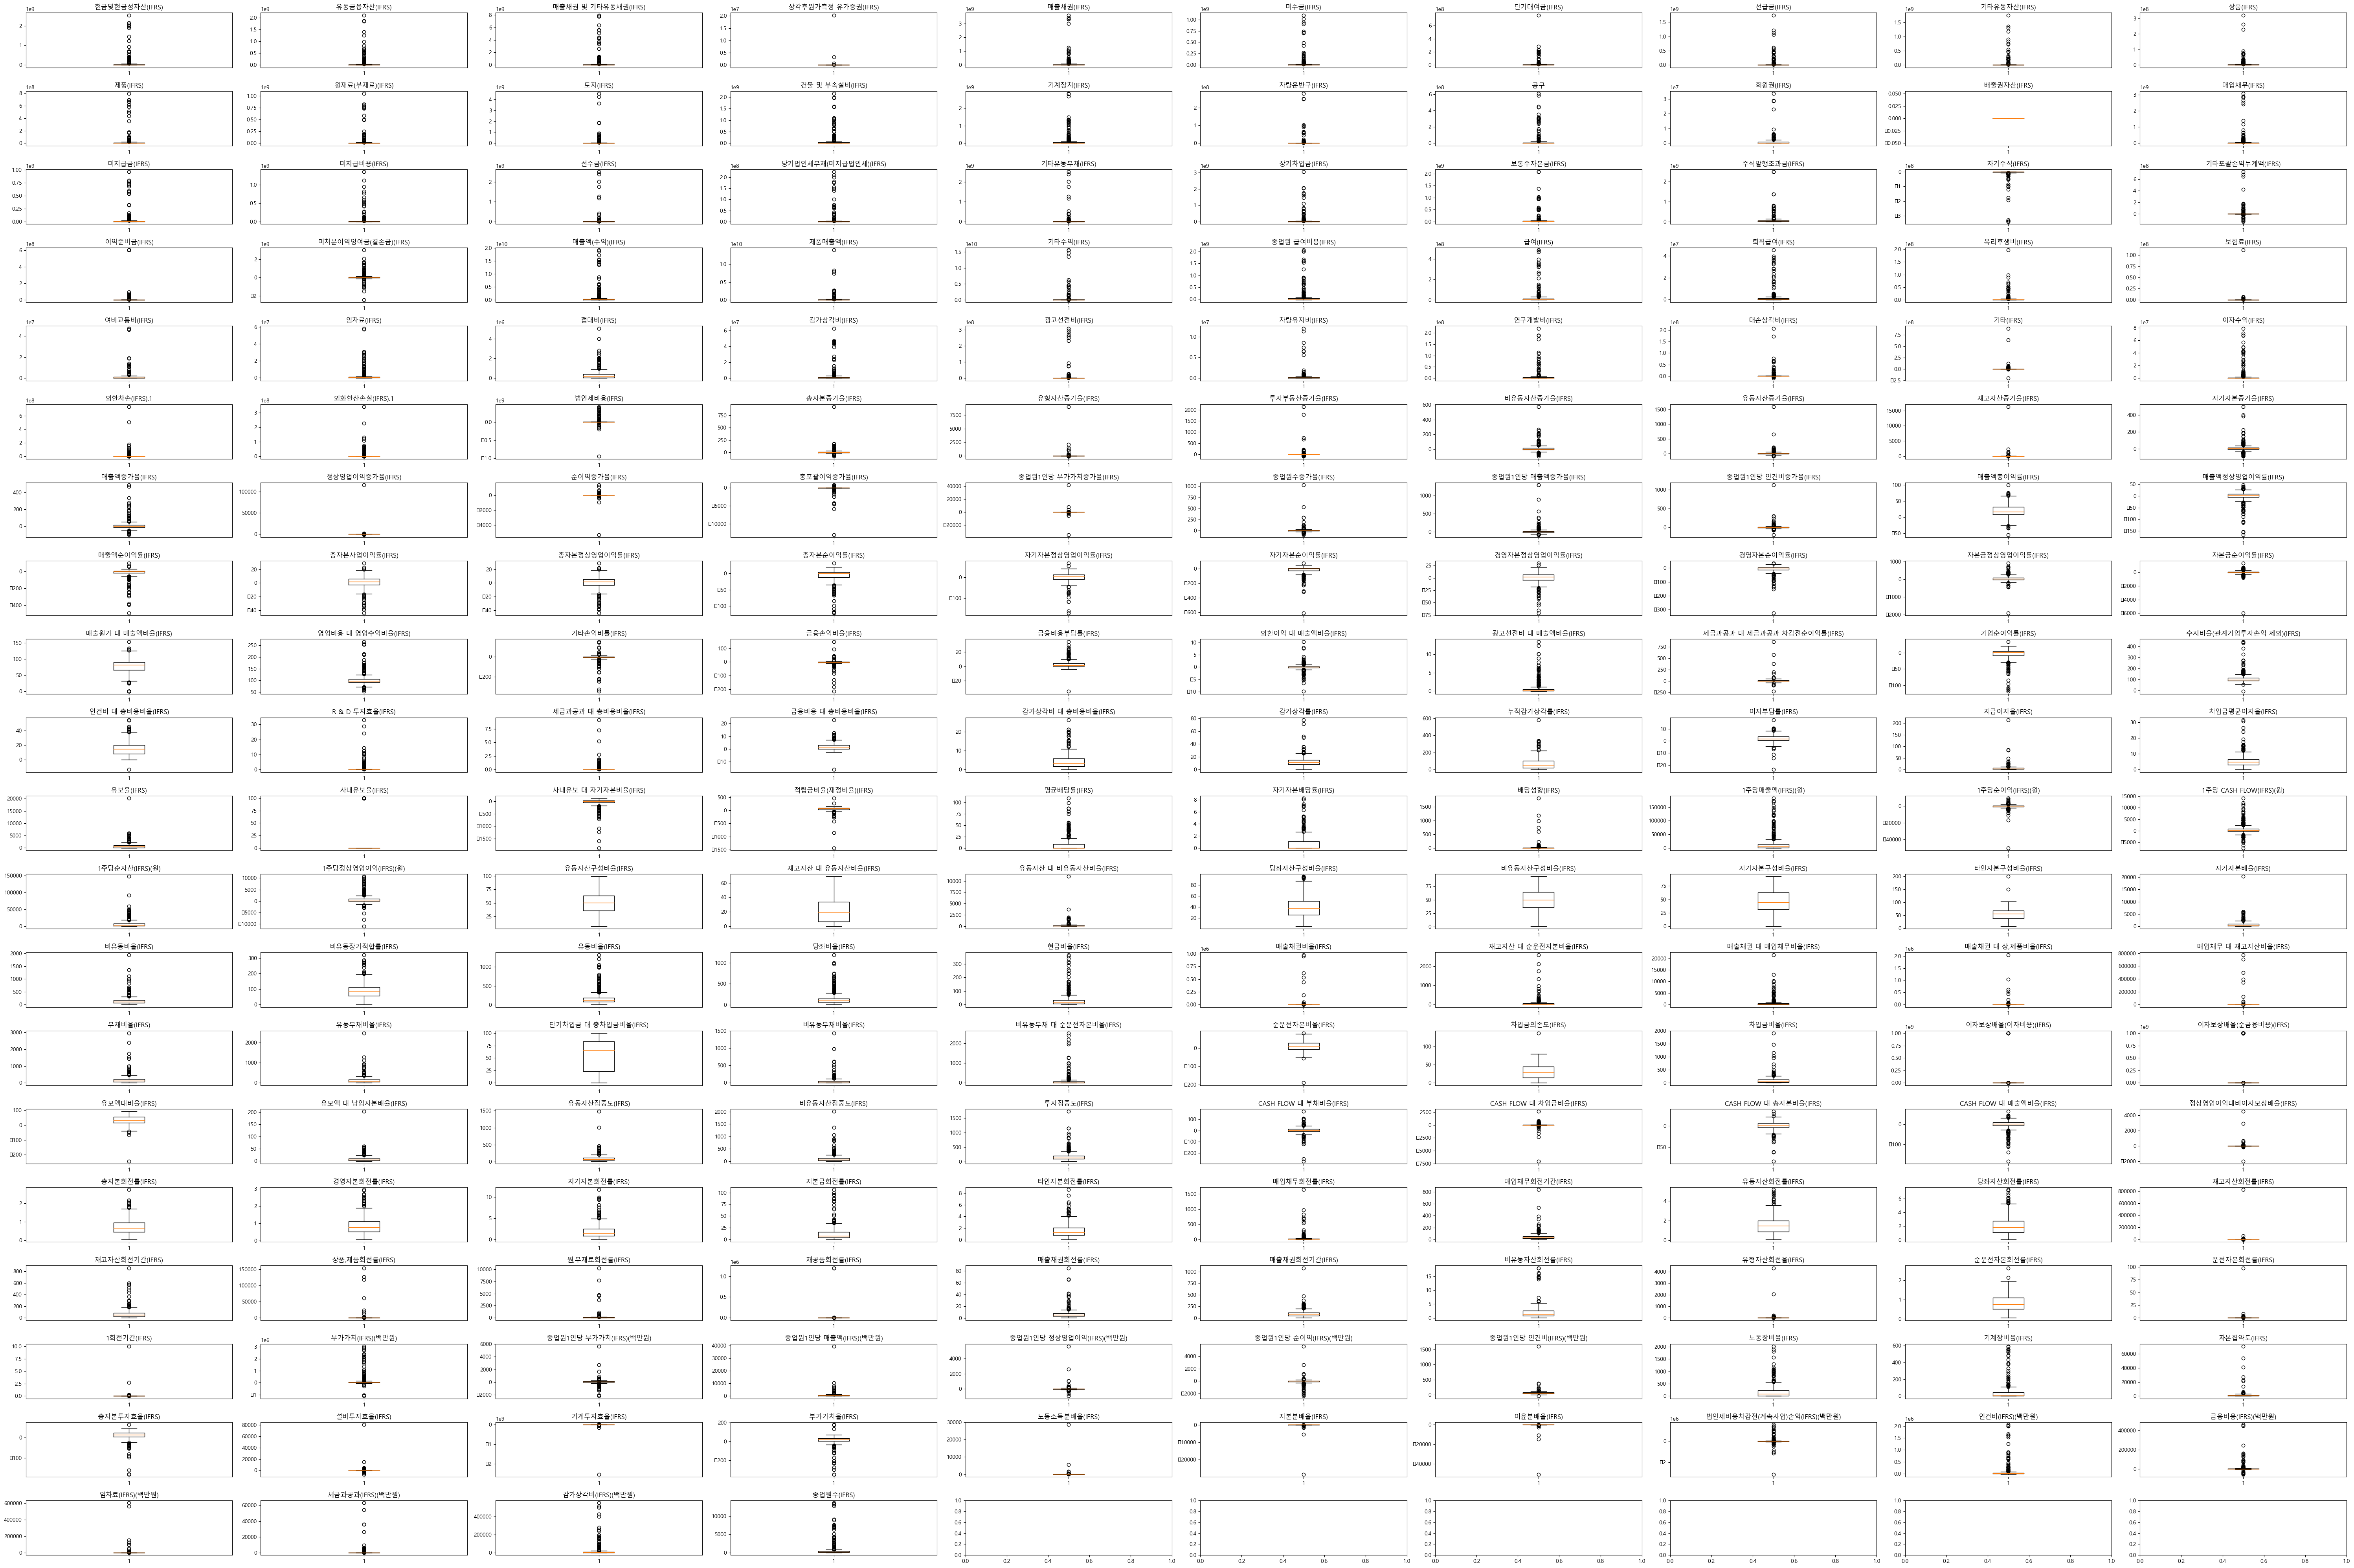

In [6]:
# from matplotlib import font_manager, rc
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.rcParams['font.family'] = 'Malgun Gothic'

selected_variables = before_winsor_feature
# 5x4 subplot 생성
fig, axes = plt.subplots(20, 10, figsize=(60, 40))
axes = axes.flatten()  # 2D axes 배열을 1D 배열로 변환

for i, var in enumerate(selected_variables):
    # i번째 axes에 i번째 변수의 히스토그램을 그림
    axes[i].boxplot(df[var])
    axes[i].set_title(var)  # 각 히스토그램에 변수 이름을 제목으로 설정

plt.tight_layout()  # subplot 간격 조정
plt.show()

In [7]:
before_winsor_feature.describe()

,현금및현금성자산(IFRS),유동금융자산(IFRS),매출채권 및 기타유동채권(IFRS),상각후원가측정 유가증권(IFRS),매출채권(IFRS),미수금(IFRS),단기대여금(IFRS),선급금(IFRS),기타유동자산(IFRS),상품(IFRS),...,노동소득분배율(IFRS),자본분배율(IFRS),이윤분배율(IFRS),법인세비용차감전(계속사업)손익(IFRS)(백만원),인건비(IFRS)(백만원),금융비용(IFRS)(백만원),임차료(IFRS)(백만원),세금과공과(IFRS)(백만원),감가상각비(IFRS)(백만원),종업원수(IFRS)
count,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,3.890000e+02,...,389.000000,389.000000,389.000000,3.890000e+02,3.890000e+02,389.000000,389.000000,389.000000,389.000000,389.000000
mean,8.232927e+07,5.939977e+07,2.863112e+08,6.233210e+04,1.156015e+08,3.079093e+07,1.268258e+07,3.901258e+07,4.114176e+07,6.463591e+06,...,161.160154,-80.954499,-232.377558,1.559327e+04,9.478764e+04,9165.102982,5618.652057,832.450591,22192.300437,768.066838
std,2.911515e+08,2.210259e+08,1.025248e+09,1.042155e+06,4.057154e+08,1.250409e+08,5.284769e+07,1.551063e+08,1.747595e+08,2.641326e+07,...,1477.557172,1475.930332,2738.067051,2.784824e+05,2.875997e+05,45912.801525,43766.772036,5145.486096,65427.520577,1886.967186
min,8.790000e+02,0.000000e+00,2.830360e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,-28477.690000,-50846.420000,-3.124361e+06,-2.386364e+04,-54363.000000,-194.640000,0.000000,0.000000,0.000000
25%,2.503144e+06,1.051000e+06,9.056679e+06,0.000000e+00,8.167975e+06,3.745310e+05,2.000000e+03,3.498490e+05,2.616570e+05,0.000000e+00,...,28.020000,0.000000,-13.330000,-1.002139e+04,5.570410e+03,128.840000,0.000000,0.000000,1350.230000,83.000000
50%,8.460020e+06,4.120500e+06,2.147539e+07,0.000000e+00,1.899071e+07,1.494613e+06,7.200000e+05,1.742473e+06,1.002740e+06,2.980640e+05,...,55.230000,26.840000,0.000000,2.779400e+02,1.280991e+04,1174.800000,0.000000,0.000000,3040.440000,187.000000
75%,3.063622e+07,1.714959e+07,6.569940e+07,0.000000e+00,4.292005e+07,7.573210e+06,5.092189e+06,7.128426e+06,4.604050e+06,2.415525e+06,...,76.440000,49.370000,21.320000,1.066846e+04,3.572547e+04,3411.040000,240.620000,0.000000,9785.160000,380.000000
max,2.542381e+09,2.099634e+09,7.980449e+09,2.029100e+07,3.595024e+09,1.095078e+09,7.598982e+08,1.743728e+09,1.752561e+09,3.214640e+08,...,28577.690000,92.530000,77.600000,1.571030e+06,2.055868e+06,459499.000000,602155.270000,62921.000000,550894.000000,13602.000000


## 1.로그변환 먼저

In [9]:
# 로그 변환할 컬럼들 지정
columns_to_log_transform = ['현금및현금성자산(IFRS)', '유동금융자산(IFRS)', '매출채권 및 기타유동채권(IFRS)',
       '상각후원가측정 유가증권(IFRS)', '매출채권(IFRS)', '미수금(IFRS)', '단기대여금(IFRS)',
       '선급금(IFRS)', '기타유동자산(IFRS)', '상품(IFRS)', '제품(IFRS)', '원재료(부재료)(IFRS)',
       '토지(IFRS)', '건물 및 부속설비(IFRS)', '기계장치(IFRS)', '차량운반구(IFRS)', '공구',
       '회원권(IFRS)', '배출권자산(IFRS)', '매입채무(IFRS)', '미지급금(IFRS)', '미지급비용(IFRS)',
       '선수금(IFRS)', '당기법인세부채(미지급법인세)(IFRS)', '기타유동부채(IFRS)', '장기차입금(IFRS)',
       '보통주자본금(IFRS)', '주식발행초과금(IFRS)', '자기주식(IFRS)', '기타포괄손익누계액(IFRS)',
       '이익준비금(IFRS)', '미처분이익잉여금(결손금)(IFRS)', '매출액(수익)(IFRS)', '제품매출액(IFRS)',
       '기타수익(IFRS)', '종업원 급여비용(IFRS)', '급여(IFRS)', '퇴직급여(IFRS)', '복리후생비(IFRS)',
       '보험료(IFRS)', '여비교통비(IFRS)', '임차료(IFRS)', '접대비(IFRS)', '감가상각비(IFRS)',
       '광고선전비(IFRS)', '차량유지비(IFRS)', '연구개발비(IFRS)', '대손상각비(IFRS)', '기타(IFRS)',
       '이자수익(IFRS)', '외환차손(IFRS).1', '외화환산손실(IFRS).1', '법인세비용(IFRS)','부가가치(IFRS)(백만원)',
       '법인세비용차감전(계속사업)손익(IFRS)(백만원)', '인건비(IFRS)(백만원)', '금융비용(IFRS)(백만원)',
       '임차료(IFRS)(백만원)', '세금과공과(IFRS)(백만원)', '감가상각비(IFRS)(백만원)', '종업원수(IFRS)']

# 1. 로그 변환 적용
X_data[columns_to_log_transform] = np.sign(X_data[columns_to_log_transform]) * np.log(np.abs(X_data[columns_to_log_transform]) + 1)

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X_data,y_data,test_size=0.3,stratify=y_data,random_state = 40)

In [12]:
n, d = X_train.shape
print("number of feature:", d)
print("number of feature:", n)

number of feature: 194
number of feature: 272


## 2. 스케일링

In [13]:
X_train_sd_scale = X_train.copy()
X_test_sd_scale = X_test.copy()
X_train_mm_scale = X_train.copy()
X_test_mm_scale = X_test.copy()
X_train_rb_scale = X_train.copy()
X_test_rb_scale = X_test.copy()

In [14]:
## train data scaling

# 나머지 컬럼들에 대해 표준화 적용
columns_to_scale = X_train_sd_scale.columns.difference(columns_to_log_transform)
sd_scaler = StandardScaler()
X_train_sd_scale[columns_to_scale] = sd_scaler.fit_transform(X_train_sd_scale[columns_to_scale])

# 나머지 컬럼들에 대해 minmax 적용
columns_to_scale = X_train_mm_scale.columns.difference(columns_to_log_transform)
mm_scaler = MinMaxScaler()
X_train_mm_scale[columns_to_scale] = mm_scaler.fit_transform(X_train_mm_scale[columns_to_scale])

# 나머지 컬럼들에 대해 robust 적용
columns_to_scale = X_train_rb_scale.columns.difference(columns_to_log_transform)
rb_scaler = RobustScaler()
X_train_rb_scale[columns_to_scale] = rb_scaler.fit_transform(X_train_rb_scale[columns_to_scale])


In [15]:
## test data scaling
# 나머지 컬럼들에 대해 표준화 적용
X_test_sd_scale[columns_to_scale] = sd_scaler.transform(X_test_sd_scale[columns_to_scale])

# 나머지 컬럼들에 대해 minmax 적용
X_test_mm_scale[columns_to_scale] = mm_scaler.transform(X_test_mm_scale[columns_to_scale])

# 나머지 컬럼들에 대해 robust 적용
X_test_rb_scale[columns_to_scale] = rb_scaler.transform(X_test_rb_scale[columns_to_scale])

## 3. Feature Selection

In [16]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [17]:
# 컬럼명 출력을 위한 옵션 설정
pd.set_option('display.max_columns', None)      # 모든 컬럼이 출력되도록 설정
# pd.set_option('display.max_colwidth', None)     # 컬럼 너비를 제한 없이 설정
pd.set_option('display.max_seq_items', None)

## (1) Sd

In [18]:
# VIF 계산 및 다중공선성 제거 함수 정의
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

def remove_multicollinearity(df, threshold=10):
    vif_data = calculate_vif(df)
    while vif_data['VIF'].max() > threshold:
        max_vif_feature = vif_data.sort_values('VIF', ascending=False).iloc[0]['feature']
        print(f"Removing '{max_vif_feature}' with VIF: {vif_data['VIF'].max()}")
        df = df.drop(columns=[max_vif_feature])
        vif_data = calculate_vif(df)
    return df

# X = X_train.replace([np.inf, -np.inf], np.nan)  # inf를 NaN으로 변환
# X_train = X.fillna(0)

# 독립 변수에 대한 다중공선성 제거 수행
X_cleaned_sd = remove_multicollinearity(X_train_sd_scale)

# 다중공선성 제거 후 라벨값과 결합
# X_123 = pd.concat([X_train, y_train], axis=1)


print("\n최종 데이터프레임:")
print(X_cleaned_sd.columns)


Removing '매출액정상영업이익률(IFRS)' with VIF: inf
Removing '부채비율(IFRS)' with VIF: 10796982683.184425
Removing '노동소득분배율(IFRS)' with VIF: 1036178.9123635757
Removing '종업원 급여비용(IFRS)' with VIF: 328068.5614335428
Removing '매출액(수익)(IFRS)' with VIF: 67714.14859207414
Removing '총자본순이익률(IFRS)' with VIF: 22737.290454443733
Removing '인건비(IFRS)(백만원)' with VIF: 22178.10537968316
Removing '매출채권 및 기타유동채권(IFRS)' with VIF: 15914.472172655274
Removing '유보율(IFRS)' with VIF: 11331.307078703923
Removing '급여(IFRS)' with VIF: 9790.668295588643
Removing '총자본정상영업이익률(IFRS)' with VIF: 7721.2662251211395
Removing '보통주자본금(IFRS)' with VIF: 5593.863942390223
Removing '유동자산구성비율(IFRS)' with VIF: 3601.0454044534863
Removing '감가상각비(IFRS)(백만원)' with VIF: 2368.6513913836825
Removing '타인자본구성비율(IFRS)' with VIF: 2011.462153243591
Removing '기타손익비률(IFRS)' with VIF: 1154.1913646029386
Removing '유보액 대 납입자본배율(IFRS)' with VIF: 926.2334317253326
Removing '미지급금(IFRS)' with VIF: 719.6748078605947
Removing '종업원1인당 순이익(IFRS)(백만원)' with VIF: 6

In [19]:
X_cleaned_sd.columns

Index(['상각후원가측정 유가증권(IFRS)', '단기대여금(IFRS)', '상품(IFRS)', '회원권(IFRS)',
       '배출권자산(IFRS)', '당기법인세부채(미지급법인세)(IFRS)', '자기주식(IFRS)', '기타포괄손익누계액(IFRS)',
       '이익준비금(IFRS)', '미처분이익잉여금(결손금)(IFRS)', '제품매출액(IFRS)', '기타수익(IFRS)',
       '접대비(IFRS)', '대손상각비(IFRS)', '기타(IFRS)', '외화환산손실(IFRS).1', '법인세비용(IFRS)',
       '유형자산증가율(IFRS)', '투자부동산증가율(IFRS)', '비유동자산증가율(IFRS)', '유동자산증가율(IFRS)',
       '재고자산증가율(IFRS)', '자기자본증가율(IFRS)', '매출액증가율(IFRS)', '정상영업이익증가율(IFRS)',
       '순이익증가율(IFRS)', '총포괄이익증가율(IFRS)', '종업원1인당 부가가치증가율(IFRS)',
       '종업원수증가율(IFRS)', '종업원1인당 매출액증가율(IFRS)', '종업원1인당 인건비증가율(IFRS)',
       '매출액총이익률(IFRS)', '자기자본정상영업이익률(IFRS)', '자본금정상영업이익률(IFRS)',
       '매출원가 대 매출액비율(IFRS)', '금융손익비율(IFRS)', '외환이익 대 매출액비율(IFRS)',
       '광고선전비 대 매출액비율(IFRS)', '세금과공과 대 세금과공과 차감전순이익률(IFRS)',
       '인건비 대 총비용비율(IFRS)', 'R & D 투자효율(IFRS)', '세금과공과 대 총비용비율(IFRS)',
       '금융비용 대 총비용비율(IFRS)', '감가상각비 대 총비용비율(IFRS)', '감가상각률(IFRS)',
       '누적감가상각률(IFRS)', '지급이자율(IFRS)', '차입금평균이자율(IFRS)', '사내유보율(IFRS)',
      

In [20]:
# sd다중공선성 제거 후
['상각후원가측정 유가증권(IFRS)', '단기대여금(IFRS)', '상품(IFRS)', '회원권(IFRS)',
       '배출권자산(IFRS)', '당기법인세부채(미지급법인세)(IFRS)', '자기주식(IFRS)', '기타포괄손익누계액(IFRS)',
       '이익준비금(IFRS)', '미처분이익잉여금(결손금)(IFRS)', '제품매출액(IFRS)', '기타수익(IFRS)',
       '접대비(IFRS)', '대손상각비(IFRS)', '기타(IFRS)', '외화환산손실(IFRS).1', '법인세비용(IFRS)',
       '유형자산증가율(IFRS)', '투자부동산증가율(IFRS)', '비유동자산증가율(IFRS)', '유동자산증가율(IFRS)',
       '재고자산증가율(IFRS)', '자기자본증가율(IFRS)', '매출액증가율(IFRS)', '정상영업이익증가율(IFRS)',
       '순이익증가율(IFRS)', '총포괄이익증가율(IFRS)', '종업원1인당 부가가치증가율(IFRS)',
       '종업원수증가율(IFRS)', '종업원1인당 매출액증가율(IFRS)', '종업원1인당 인건비증가율(IFRS)',
       '매출액총이익률(IFRS)', '자기자본정상영업이익률(IFRS)', '자본금정상영업이익률(IFRS)',
       '매출원가 대 매출액비율(IFRS)', '금융손익비율(IFRS)', '외환이익 대 매출액비율(IFRS)',
       '광고선전비 대 매출액비율(IFRS)', '세금과공과 대 세금과공과 차감전순이익률(IFRS)',
       '인건비 대 총비용비율(IFRS)', 'R & D 투자효율(IFRS)', '세금과공과 대 총비용비율(IFRS)',
       '금융비용 대 총비용비율(IFRS)', '감가상각비 대 총비용비율(IFRS)', '감가상각률(IFRS)',
       '누적감가상각률(IFRS)', '지급이자율(IFRS)', '차입금평균이자율(IFRS)', '사내유보율(IFRS)',
       '사내유보 대 자기자본비율(IFRS)', '적립금비율(재정비율)(IFRS)', '평균배당률(IFRS)',
       '자기자본배당률(IFRS)', '배당성향(IFRS)', '1주당매출액(IFRS)(원)', '1주당순이익(IFRS)(원)',
       '1주당 CASH FLOW(IFRS)(원)', '1주당정상영업이익(IFRS)(원)', '재고자산 대 유동자산비율(IFRS)',
       '자기자본배율(IFRS)', '비유동장기적합률(IFRS)', '유동비율(IFRS)', '현금비율(IFRS)',
       '재고자산 대 순운전자본비율(IFRS)', '매출채권 대 매입채무비율(IFRS)', '매출채권 대 상,제품비율(IFRS)',
       '매입채무 대 재고자산비율(IFRS)', '단기차입금 대 총차입금비율(IFRS)', '비유동부채비율(IFRS)',
       '비유동부채 대 순운전자본비율(IFRS)', '차입금의존도(IFRS)', '이자보상배율(이자비용)(IFRS)',
       '이자보상배율(순금융비용)(IFRS)', '비유동자산집중도(IFRS)', '투자집중도(IFRS)',
       'CASH FLOW 대 부채비율(IFRS)', 'CASH FLOW 대 차입금비율(IFRS)',
       'CASH FLOW 대 매출액비율(IFRS)', '정상영업이익대비이자보상배율(IFRS)', '자기자본회전률(IFRS)',
       '자본금회전률(IFRS)', '타인자본회전률(IFRS)', '매입채무회전률(IFRS)', '매입채무회전기간(IFRS)',
       '당좌자산회전률(IFRS)', '재고자산회전률(IFRS)', '상품,제품회전률(IFRS)', '원,부재료회전률(IFRS)',
       '재공품회전률(IFRS)', '매출채권회전률(IFRS)', '매출채권회전기간(IFRS)', '비유동자산회전률(IFRS)',
       '운전자본회전률(IFRS)', '부가가치(IFRS)(백만원)', '종업원1인당 부가가치(IFRS)(백만원)',
       '노동장비율(IFRS)', '기계장비율(IFRS)', '자본집약도(IFRS)', '총자본투자효율(IFRS)',
       '설비투자효율(IFRS)', '기계투자효율(IFRS)', '자본분배율(IFRS)',
       '법인세비용차감전(계속사업)손익(IFRS)(백만원)', '임차료(IFRS)(백만원)', '세금과공과(IFRS)(백만원)']

['상각후원가측정 유가증권(IFRS)',
 '단기대여금(IFRS)',
 '상품(IFRS)',
 '회원권(IFRS)',
 '배출권자산(IFRS)',
 '당기법인세부채(미지급법인세)(IFRS)',
 '자기주식(IFRS)',
 '기타포괄손익누계액(IFRS)',
 '이익준비금(IFRS)',
 '미처분이익잉여금(결손금)(IFRS)',
 '제품매출액(IFRS)',
 '기타수익(IFRS)',
 '접대비(IFRS)',
 '대손상각비(IFRS)',
 '기타(IFRS)',
 '외화환산손실(IFRS).1',
 '법인세비용(IFRS)',
 '유형자산증가율(IFRS)',
 '투자부동산증가율(IFRS)',
 '비유동자산증가율(IFRS)',
 '유동자산증가율(IFRS)',
 '재고자산증가율(IFRS)',
 '자기자본증가율(IFRS)',
 '매출액증가율(IFRS)',
 '정상영업이익증가율(IFRS)',
 '순이익증가율(IFRS)',
 '총포괄이익증가율(IFRS)',
 '종업원1인당 부가가치증가율(IFRS)',
 '종업원수증가율(IFRS)',
 '종업원1인당 매출액증가율(IFRS)',
 '종업원1인당 인건비증가율(IFRS)',
 '매출액총이익률(IFRS)',
 '자기자본정상영업이익률(IFRS)',
 '자본금정상영업이익률(IFRS)',
 '매출원가 대 매출액비율(IFRS)',
 '금융손익비율(IFRS)',
 '외환이익 대 매출액비율(IFRS)',
 '광고선전비 대 매출액비율(IFRS)',
 '세금과공과 대 세금과공과 차감전순이익률(IFRS)',
 '인건비 대 총비용비율(IFRS)',
 'R & D 투자효율(IFRS)',
 '세금과공과 대 총비용비율(IFRS)',
 '금융비용 대 총비용비율(IFRS)',
 '감가상각비 대 총비용비율(IFRS)',
 '감가상각률(IFRS)',
 '누적감가상각률(IFRS)',
 '지급이자율(IFRS)',
 '차입금평균이자율(IFRS)',
 '사내유보율(IFRS)',
 '사내유보 대 자기자본비율(IFRS)',
 '적립금비율(재정비율)(IFRS)',
 '평균배당률(I

In [21]:
X_train_sd = X_train_sd_scale[['상각후원가측정 유가증권(IFRS)', '단기대여금(IFRS)', '상품(IFRS)', '회원권(IFRS)',
       '배출권자산(IFRS)', '당기법인세부채(미지급법인세)(IFRS)', '자기주식(IFRS)', '기타포괄손익누계액(IFRS)',
       '이익준비금(IFRS)', '미처분이익잉여금(결손금)(IFRS)', '제품매출액(IFRS)', '기타수익(IFRS)',
       '접대비(IFRS)', '대손상각비(IFRS)', '기타(IFRS)', '외화환산손실(IFRS).1', '법인세비용(IFRS)',
       '유형자산증가율(IFRS)', '투자부동산증가율(IFRS)', '비유동자산증가율(IFRS)', '유동자산증가율(IFRS)',
       '재고자산증가율(IFRS)', '자기자본증가율(IFRS)', '매출액증가율(IFRS)', '정상영업이익증가율(IFRS)',
       '순이익증가율(IFRS)', '총포괄이익증가율(IFRS)', '종업원1인당 부가가치증가율(IFRS)',
       '종업원수증가율(IFRS)', '종업원1인당 매출액증가율(IFRS)', '종업원1인당 인건비증가율(IFRS)',
       '매출액총이익률(IFRS)', '자기자본정상영업이익률(IFRS)', '자본금정상영업이익률(IFRS)',
       '매출원가 대 매출액비율(IFRS)', '금융손익비율(IFRS)', '외환이익 대 매출액비율(IFRS)',
       '광고선전비 대 매출액비율(IFRS)', '세금과공과 대 세금과공과 차감전순이익률(IFRS)',
       '인건비 대 총비용비율(IFRS)', 'R & D 투자효율(IFRS)', '세금과공과 대 총비용비율(IFRS)',
       '금융비용 대 총비용비율(IFRS)', '감가상각비 대 총비용비율(IFRS)', '감가상각률(IFRS)',
       '누적감가상각률(IFRS)', '지급이자율(IFRS)', '차입금평균이자율(IFRS)', '사내유보율(IFRS)',
       '사내유보 대 자기자본비율(IFRS)', '적립금비율(재정비율)(IFRS)', '평균배당률(IFRS)',
       '자기자본배당률(IFRS)', '배당성향(IFRS)', '1주당매출액(IFRS)(원)', '1주당순이익(IFRS)(원)',
       '1주당 CASH FLOW(IFRS)(원)', '1주당정상영업이익(IFRS)(원)', '재고자산 대 유동자산비율(IFRS)',
       '자기자본배율(IFRS)', '비유동장기적합률(IFRS)', '유동비율(IFRS)', '현금비율(IFRS)',
       '재고자산 대 순운전자본비율(IFRS)', '매출채권 대 매입채무비율(IFRS)', '매출채권 대 상,제품비율(IFRS)',
       '매입채무 대 재고자산비율(IFRS)', '단기차입금 대 총차입금비율(IFRS)', '비유동부채비율(IFRS)',
       '비유동부채 대 순운전자본비율(IFRS)', '차입금의존도(IFRS)', '이자보상배율(이자비용)(IFRS)',
       '이자보상배율(순금융비용)(IFRS)', '비유동자산집중도(IFRS)', '투자집중도(IFRS)',
       'CASH FLOW 대 부채비율(IFRS)', 'CASH FLOW 대 차입금비율(IFRS)',
       'CASH FLOW 대 매출액비율(IFRS)', '정상영업이익대비이자보상배율(IFRS)', '자기자본회전률(IFRS)',
       '자본금회전률(IFRS)', '타인자본회전률(IFRS)', '매입채무회전률(IFRS)', '매입채무회전기간(IFRS)',
       '당좌자산회전률(IFRS)', '재고자산회전률(IFRS)', '상품,제품회전률(IFRS)', '원,부재료회전률(IFRS)',
       '재공품회전률(IFRS)', '매출채권회전률(IFRS)', '매출채권회전기간(IFRS)', '비유동자산회전률(IFRS)',
       '운전자본회전률(IFRS)', '부가가치(IFRS)(백만원)', '종업원1인당 부가가치(IFRS)(백만원)',
       '노동장비율(IFRS)', '기계장비율(IFRS)', '자본집약도(IFRS)', '총자본투자효율(IFRS)',
       '설비투자효율(IFRS)', '기계투자효율(IFRS)', '자본분배율(IFRS)',
       '법인세비용차감전(계속사업)손익(IFRS)(백만원)', '임차료(IFRS)(백만원)', '세금과공과(IFRS)(백만원)']]
X_test_sd = X_test_sd_scale[['상각후원가측정 유가증권(IFRS)', '단기대여금(IFRS)', '상품(IFRS)', '회원권(IFRS)',
       '배출권자산(IFRS)', '당기법인세부채(미지급법인세)(IFRS)', '자기주식(IFRS)', '기타포괄손익누계액(IFRS)',
       '이익준비금(IFRS)', '미처분이익잉여금(결손금)(IFRS)', '제품매출액(IFRS)', '기타수익(IFRS)',
       '접대비(IFRS)', '대손상각비(IFRS)', '기타(IFRS)', '외화환산손실(IFRS).1', '법인세비용(IFRS)',
       '유형자산증가율(IFRS)', '투자부동산증가율(IFRS)', '비유동자산증가율(IFRS)', '유동자산증가율(IFRS)',
       '재고자산증가율(IFRS)', '자기자본증가율(IFRS)', '매출액증가율(IFRS)', '정상영업이익증가율(IFRS)',
       '순이익증가율(IFRS)', '총포괄이익증가율(IFRS)', '종업원1인당 부가가치증가율(IFRS)',
       '종업원수증가율(IFRS)', '종업원1인당 매출액증가율(IFRS)', '종업원1인당 인건비증가율(IFRS)',
       '매출액총이익률(IFRS)', '자기자본정상영업이익률(IFRS)', '자본금정상영업이익률(IFRS)',
       '매출원가 대 매출액비율(IFRS)', '금융손익비율(IFRS)', '외환이익 대 매출액비율(IFRS)',
       '광고선전비 대 매출액비율(IFRS)', '세금과공과 대 세금과공과 차감전순이익률(IFRS)',
       '인건비 대 총비용비율(IFRS)', 'R & D 투자효율(IFRS)', '세금과공과 대 총비용비율(IFRS)',
       '금융비용 대 총비용비율(IFRS)', '감가상각비 대 총비용비율(IFRS)', '감가상각률(IFRS)',
       '누적감가상각률(IFRS)', '지급이자율(IFRS)', '차입금평균이자율(IFRS)', '사내유보율(IFRS)',
       '사내유보 대 자기자본비율(IFRS)', '적립금비율(재정비율)(IFRS)', '평균배당률(IFRS)',
       '자기자본배당률(IFRS)', '배당성향(IFRS)', '1주당매출액(IFRS)(원)', '1주당순이익(IFRS)(원)',
       '1주당 CASH FLOW(IFRS)(원)', '1주당정상영업이익(IFRS)(원)', '재고자산 대 유동자산비율(IFRS)',
       '자기자본배율(IFRS)', '비유동장기적합률(IFRS)', '유동비율(IFRS)', '현금비율(IFRS)',
       '재고자산 대 순운전자본비율(IFRS)', '매출채권 대 매입채무비율(IFRS)', '매출채권 대 상,제품비율(IFRS)',
       '매입채무 대 재고자산비율(IFRS)', '단기차입금 대 총차입금비율(IFRS)', '비유동부채비율(IFRS)',
       '비유동부채 대 순운전자본비율(IFRS)', '차입금의존도(IFRS)', '이자보상배율(이자비용)(IFRS)',
       '이자보상배율(순금융비용)(IFRS)', '비유동자산집중도(IFRS)', '투자집중도(IFRS)',
       'CASH FLOW 대 부채비율(IFRS)', 'CASH FLOW 대 차입금비율(IFRS)',
       'CASH FLOW 대 매출액비율(IFRS)', '정상영업이익대비이자보상배율(IFRS)', '자기자본회전률(IFRS)',
       '자본금회전률(IFRS)', '타인자본회전률(IFRS)', '매입채무회전률(IFRS)', '매입채무회전기간(IFRS)',
       '당좌자산회전률(IFRS)', '재고자산회전률(IFRS)', '상품,제품회전률(IFRS)', '원,부재료회전률(IFRS)',
       '재공품회전률(IFRS)', '매출채권회전률(IFRS)', '매출채권회전기간(IFRS)', '비유동자산회전률(IFRS)',
       '운전자본회전률(IFRS)', '부가가치(IFRS)(백만원)', '종업원1인당 부가가치(IFRS)(백만원)',
       '노동장비율(IFRS)', '기계장비율(IFRS)', '자본집약도(IFRS)', '총자본투자효율(IFRS)',
       '설비투자효율(IFRS)', '기계투자효율(IFRS)', '자본분배율(IFRS)',
       '법인세비용차감전(계속사업)손익(IFRS)(백만원)', '임차료(IFRS)(백만원)', '세금과공과(IFRS)(백만원)']]

In [22]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from scipy.stats import ttest_ind

# 예시 데이터 준비 (X: 특성, y: 타겟)
# X = 데이터프레임 (특성), y = 타겟 벡터

# 1. Lasso 회귀로 피쳐 선택
lasso = LassoCV(cv=5)  # 교차 검증을 사용하여 최적의 alpha를 선택
lasso.fit(X_train_sd, y_train)

# 중요 피쳐 추출 (lasso.coef_는 선택된 피쳐들의 계수)
selected_features = X_train_sd.columns[(lasso.coef_ != 0)]

# 2. 선택된 피쳐들에 대해 t-test 수행
p_values = []

for feature in selected_features:
    # 각 피쳐별로 t-test 수행 (클래스가 2개로 가정, y1과 y2를 기준으로)
    group1 = X_train_sd[y_train == 0][feature]  # y == 0인 그룹의 데이터
    group2 = X_train_sd[y_train == 1][feature]  # y == 1인 그룹의 데이터
    
    _, p_value = ttest_ind(group1, group2)
    p_values.append((feature, p_value))

# 3. p-value를 기준으로 피쳐 정렬
sorted_features = sorted(p_values, key=lambda x: x[1])

# p-value가 유효한 순서대로 출력
sorted_features_df = pd.DataFrame(sorted_features, columns=["Feature", "p-value"])

print(sorted_features_df)


                        Feature   p-value
0             인건비 대 총비용비율(IFRS)  0.000003
1                     회원권(IFRS)  0.000972
2                   제품매출액(IFRS)  0.004442
3                임차료(IFRS)(백만원)  0.008941
4            매출원가 대 매출액비율(IFRS)  0.009815
5                      기타(IFRS)  0.014014
6                  자기자본배율(IFRS)  0.032805
7                     접대비(IFRS)  0.033678
8                   대손상각비(IFRS)  0.036839
9                    자기주식(IFRS)  0.075355
10                  법인세비용(IFRS)  0.076188
11              부가가치(IFRS)(백만원)  0.081365
12  법인세비용차감전(계속사업)손익(IFRS)(백만원)  0.096692
13               외화환산손실(IFRS).1  0.120464
14              기타포괄손익누계액(IFRS)  0.130856
15                  이익준비금(IFRS)  0.146447
16                   기타수익(IFRS)  0.230681
17          미처분이익잉여금(결손금)(IFRS)  0.243365
18                     상품(IFRS)  0.596572
19                  단기대여금(IFRS)  0.908726


In [24]:
list(sorted_features_df['Feature'])

['인건비 대 총비용비율(IFRS)',
 '회원권(IFRS)',
 '제품매출액(IFRS)',
 '임차료(IFRS)(백만원)',
 '매출원가 대 매출액비율(IFRS)',
 '기타(IFRS)',
 '자기자본배율(IFRS)',
 '접대비(IFRS)',
 '대손상각비(IFRS)',
 '자기주식(IFRS)',
 '법인세비용(IFRS)',
 '부가가치(IFRS)(백만원)',
 '법인세비용차감전(계속사업)손익(IFRS)(백만원)',
 '외화환산손실(IFRS).1',
 '기타포괄손익누계액(IFRS)',
 '이익준비금(IFRS)',
 '기타수익(IFRS)',
 '미처분이익잉여금(결손금)(IFRS)',
 '상품(IFRS)',
 '단기대여금(IFRS)']

In [25]:
X_train_sd = X_train_sd_scale[['인건비 대 총비용비율(IFRS)',
 '회원권(IFRS)',
 '제품매출액(IFRS)',
 '임차료(IFRS)(백만원)',
 '매출원가 대 매출액비율(IFRS)',
 '기타(IFRS)',
 '자기자본배율(IFRS)',
 '접대비(IFRS)',
 '대손상각비(IFRS)',
 '자기주식(IFRS)',
 '법인세비용(IFRS)',
 '부가가치(IFRS)(백만원)',
 '법인세비용차감전(계속사업)손익(IFRS)(백만원)',
 '외화환산손실(IFRS).1',
 '기타포괄손익누계액(IFRS)',
 '이익준비금(IFRS)',
 '기타수익(IFRS)',
 '미처분이익잉여금(결손금)(IFRS)',
 '상품(IFRS)',
 '단기대여금(IFRS)']]
X_test_sd = X_test_sd_scale[['인건비 대 총비용비율(IFRS)',
 '회원권(IFRS)',
 '제품매출액(IFRS)',
 '임차료(IFRS)(백만원)',
 '매출원가 대 매출액비율(IFRS)',
 '기타(IFRS)',
 '자기자본배율(IFRS)',
 '접대비(IFRS)',
 '대손상각비(IFRS)',
 '자기주식(IFRS)',
 '법인세비용(IFRS)',
 '부가가치(IFRS)(백만원)',
 '법인세비용차감전(계속사업)손익(IFRS)(백만원)',
 '외화환산손실(IFRS).1',
 '기타포괄손익누계액(IFRS)',
 '이익준비금(IFRS)',
 '기타수익(IFRS)',
 '미처분이익잉여금(결손금)(IFRS)',
 '상품(IFRS)',
 '단기대여금(IFRS)']]

(2) mm 스케일링

In [28]:
# VIF 계산 및 다중공선성 제거 함수 정의
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

def remove_multicollinearity(df, threshold=10):
    vif_data = calculate_vif(df)
    while vif_data['VIF'].max() > threshold:
        max_vif_feature = vif_data.sort_values('VIF', ascending=False).iloc[0]['feature']
        print(f"Removing '{max_vif_feature}' with VIF: {vif_data['VIF'].max()}")
        df = df.drop(columns=[max_vif_feature])
        vif_data = calculate_vif(df)
    return df

# X = X_train.replace([np.inf, -np.inf], np.nan)  # inf를 NaN으로 변환
# X_train = X.fillna(0)

# 독립 변수에 대한 다중공선성 제거 수행
X_cleaned_mm = remove_multicollinearity(X_train_mm_scale)

# 다중공선성 제거 후 라벨값과 결합
# X_123 = pd.concat([X_train, y_train], axis=1)


print("\n최종 데이터프레임:")
print(X_cleaned_mm.columns)


Removing '매출액정상영업이익률(IFRS)' with VIF: 16222552676.186481
Removing '부채비율(IFRS)' with VIF: 17134702864.422531
Removing '종업원 급여비용(IFRS)' with VIF: 1613870062.3676102
Removing '총자본순이익률(IFRS)' with VIF: 929321.9067719912
Removing '자본분배율(IFRS)' with VIF: 321008.0765242427
Removing '총자본정상영업이익률(IFRS)' with VIF: 184914.29856463437
Removing '매출액(수익)(IFRS)' with VIF: 156029.23828044682
Removing '기타손익비률(IFRS)' with VIF: 108489.65371501574
Removing '경영자본순이익률(IFRS)' with VIF: 90381.90106045813
Removing '이윤분배율(IFRS)' with VIF: 70300.39572240801
Removing '자본금순이익률(IFRS)' with VIF: 28136.94593095326
Removing '인건비(IFRS)(백만원)' with VIF: 26306.28674923063
Removing '부가가치율(IFRS)' with VIF: 21791.865012787297
Removing '종업원1인당 순이익(IFRS)(백만원)' with VIF: 19095.51933222589
Removing '유동자산구성비율(IFRS)' with VIF: 17024.343758596424
Removing '자기자본순이익률(IFRS)' with VIF: 13425.711972853549
Removing '보통주자본금(IFRS)' with VIF: 13371.588191888539
Removing '급여(IFRS)' with VIF: 11720.865250709565
Removing '유보율(IFRS)' with VIF: 1

In [29]:
# mm 다중공선성 제거 후
['상각후원가측정 유가증권(IFRS)', '단기대여금(IFRS)', '상품(IFRS)', '공구', '회원권(IFRS)',
       '배출권자산(IFRS)', '당기법인세부채(미지급법인세)(IFRS)', '자기주식(IFRS)', '기타포괄손익누계액(IFRS)',
       '이익준비금(IFRS)', '미처분이익잉여금(결손금)(IFRS)', '제품매출액(IFRS)', '기타수익(IFRS)',
       '접대비(IFRS)', '연구개발비(IFRS)', '대손상각비(IFRS)', '기타(IFRS)', '외화환산손실(IFRS).1',
       '법인세비용(IFRS)', '유형자산증가율(IFRS)', '투자부동산증가율(IFRS)', '비유동자산증가율(IFRS)',
       '재고자산증가율(IFRS)', '정상영업이익증가율(IFRS)', '종업원수증가율(IFRS)',
       '종업원1인당 매출액증가율(IFRS)', '광고선전비 대 매출액비율(IFRS)', '수지비율(관계기업투자손익 제외)(IFRS)',
       'R & D 투자효율(IFRS)', '세금과공과 대 총비용비율(IFRS)', '감가상각비 대 총비용비율(IFRS)',
       '감가상각률(IFRS)', '누적감가상각률(IFRS)', '지급이자율(IFRS)', '사내유보율(IFRS)',
       '평균배당률(IFRS)', '자기자본배당률(IFRS)', '배당성향(IFRS)', '1주당매출액(IFRS)(원)',
       '1주당순자산(IFRS)(원)', '재고자산 대 유동자산비율(IFRS)', '자기자본배율(IFRS)', '당좌비율(IFRS)',
       '현금비율(IFRS)', '재고자산 대 순운전자본비율(IFRS)', '매출채권 대 매입채무비율(IFRS)',
       '매출채권 대 상,제품비율(IFRS)', '매입채무 대 재고자산비율(IFRS)', '유동부채비율(IFRS)',
       '단기차입금 대 총차입금비율(IFRS)', '비유동부채비율(IFRS)', '비유동부채 대 순운전자본비율(IFRS)',
       '이자보상배율(이자비용)(IFRS)', '이자보상배율(순금융비용)(IFRS)', '유동자산집중도(IFRS)',
       '비유동자산집중도(IFRS)', '자본금회전률(IFRS)', '타인자본회전률(IFRS)', '매입채무회전률(IFRS)',
       '매입채무회전기간(IFRS)', '재고자산회전률(IFRS)', '상품,제품회전률(IFRS)', '원,부재료회전률(IFRS)',
       '재공품회전률(IFRS)', '매출채권회전률(IFRS)', '비유동자산회전률(IFRS)', '유형자산회전율(IFRS)',
       '운전자본회전률(IFRS)', '1회전기간(IFRS)', '부가가치(IFRS)(백만원)', '노동장비율(IFRS)',
       '기계장비율(IFRS)', '자본집약도(IFRS)', '노동소득분배율(IFRS)',
       '법인세비용차감전(계속사업)손익(IFRS)(백만원)', '임차료(IFRS)(백만원)', '세금과공과(IFRS)(백만원)']

['상각후원가측정 유가증권(IFRS)',
 '단기대여금(IFRS)',
 '상품(IFRS)',
 '공구',
 '회원권(IFRS)',
 '배출권자산(IFRS)',
 '당기법인세부채(미지급법인세)(IFRS)',
 '자기주식(IFRS)',
 '기타포괄손익누계액(IFRS)',
 '이익준비금(IFRS)',
 '미처분이익잉여금(결손금)(IFRS)',
 '제품매출액(IFRS)',
 '기타수익(IFRS)',
 '접대비(IFRS)',
 '연구개발비(IFRS)',
 '대손상각비(IFRS)',
 '기타(IFRS)',
 '외화환산손실(IFRS).1',
 '법인세비용(IFRS)',
 '유형자산증가율(IFRS)',
 '투자부동산증가율(IFRS)',
 '비유동자산증가율(IFRS)',
 '재고자산증가율(IFRS)',
 '정상영업이익증가율(IFRS)',
 '종업원수증가율(IFRS)',
 '종업원1인당 매출액증가율(IFRS)',
 '광고선전비 대 매출액비율(IFRS)',
 '수지비율(관계기업투자손익 제외)(IFRS)',
 'R & D 투자효율(IFRS)',
 '세금과공과 대 총비용비율(IFRS)',
 '감가상각비 대 총비용비율(IFRS)',
 '감가상각률(IFRS)',
 '누적감가상각률(IFRS)',
 '지급이자율(IFRS)',
 '사내유보율(IFRS)',
 '평균배당률(IFRS)',
 '자기자본배당률(IFRS)',
 '배당성향(IFRS)',
 '1주당매출액(IFRS)(원)',
 '1주당순자산(IFRS)(원)',
 '재고자산 대 유동자산비율(IFRS)',
 '자기자본배율(IFRS)',
 '당좌비율(IFRS)',
 '현금비율(IFRS)',
 '재고자산 대 순운전자본비율(IFRS)',
 '매출채권 대 매입채무비율(IFRS)',
 '매출채권 대 상,제품비율(IFRS)',
 '매입채무 대 재고자산비율(IFRS)',
 '유동부채비율(IFRS)',
 '단기차입금 대 총차입금비율(IFRS)',
 '비유동부채비율(IFRS)',
 '비유동부채 대 순운전자본비율(IFRS)',
 '이자보상배율(이자비용)(IFRS

In [30]:
X_train_mm = X_train_mm_scale[['상각후원가측정 유가증권(IFRS)', '단기대여금(IFRS)', '상품(IFRS)', '공구', '회원권(IFRS)',
       '배출권자산(IFRS)', '당기법인세부채(미지급법인세)(IFRS)', '자기주식(IFRS)', '기타포괄손익누계액(IFRS)',
       '이익준비금(IFRS)', '미처분이익잉여금(결손금)(IFRS)', '제품매출액(IFRS)', '기타수익(IFRS)',
       '접대비(IFRS)', '연구개발비(IFRS)', '대손상각비(IFRS)', '기타(IFRS)', '외화환산손실(IFRS).1',
       '법인세비용(IFRS)', '유형자산증가율(IFRS)', '투자부동산증가율(IFRS)', '비유동자산증가율(IFRS)',
       '재고자산증가율(IFRS)', '정상영업이익증가율(IFRS)', '종업원수증가율(IFRS)',
       '종업원1인당 매출액증가율(IFRS)', '광고선전비 대 매출액비율(IFRS)', '수지비율(관계기업투자손익 제외)(IFRS)',
       'R & D 투자효율(IFRS)', '세금과공과 대 총비용비율(IFRS)', '감가상각비 대 총비용비율(IFRS)',
       '감가상각률(IFRS)', '누적감가상각률(IFRS)', '지급이자율(IFRS)', '사내유보율(IFRS)',
       '평균배당률(IFRS)', '자기자본배당률(IFRS)', '배당성향(IFRS)', '1주당매출액(IFRS)(원)',
       '1주당순자산(IFRS)(원)', '재고자산 대 유동자산비율(IFRS)', '자기자본배율(IFRS)', '당좌비율(IFRS)',
       '현금비율(IFRS)', '재고자산 대 순운전자본비율(IFRS)', '매출채권 대 매입채무비율(IFRS)',
       '매출채권 대 상,제품비율(IFRS)', '매입채무 대 재고자산비율(IFRS)', '유동부채비율(IFRS)',
       '단기차입금 대 총차입금비율(IFRS)', '비유동부채비율(IFRS)', '비유동부채 대 순운전자본비율(IFRS)',
       '이자보상배율(이자비용)(IFRS)', '이자보상배율(순금융비용)(IFRS)', '유동자산집중도(IFRS)',
       '비유동자산집중도(IFRS)', '자본금회전률(IFRS)', '타인자본회전률(IFRS)', '매입채무회전률(IFRS)',
       '매입채무회전기간(IFRS)', '재고자산회전률(IFRS)', '상품,제품회전률(IFRS)', '원,부재료회전률(IFRS)',
       '재공품회전률(IFRS)', '매출채권회전률(IFRS)', '비유동자산회전률(IFRS)', '유형자산회전율(IFRS)',
       '운전자본회전률(IFRS)', '1회전기간(IFRS)', '부가가치(IFRS)(백만원)', '노동장비율(IFRS)',
       '기계장비율(IFRS)', '자본집약도(IFRS)', '노동소득분배율(IFRS)',
       '법인세비용차감전(계속사업)손익(IFRS)(백만원)', '임차료(IFRS)(백만원)', '세금과공과(IFRS)(백만원)']]
X_test_mm = X_test_mm_scale[['상각후원가측정 유가증권(IFRS)', '단기대여금(IFRS)', '상품(IFRS)', '공구', '회원권(IFRS)',
       '배출권자산(IFRS)', '당기법인세부채(미지급법인세)(IFRS)', '자기주식(IFRS)', '기타포괄손익누계액(IFRS)',
       '이익준비금(IFRS)', '미처분이익잉여금(결손금)(IFRS)', '제품매출액(IFRS)', '기타수익(IFRS)',
       '접대비(IFRS)', '연구개발비(IFRS)', '대손상각비(IFRS)', '기타(IFRS)', '외화환산손실(IFRS).1',
       '법인세비용(IFRS)', '유형자산증가율(IFRS)', '투자부동산증가율(IFRS)', '비유동자산증가율(IFRS)',
       '재고자산증가율(IFRS)', '정상영업이익증가율(IFRS)', '종업원수증가율(IFRS)',
       '종업원1인당 매출액증가율(IFRS)', '광고선전비 대 매출액비율(IFRS)', '수지비율(관계기업투자손익 제외)(IFRS)',
       'R & D 투자효율(IFRS)', '세금과공과 대 총비용비율(IFRS)', '감가상각비 대 총비용비율(IFRS)',
       '감가상각률(IFRS)', '누적감가상각률(IFRS)', '지급이자율(IFRS)', '사내유보율(IFRS)',
       '평균배당률(IFRS)', '자기자본배당률(IFRS)', '배당성향(IFRS)', '1주당매출액(IFRS)(원)',
       '1주당순자산(IFRS)(원)', '재고자산 대 유동자산비율(IFRS)', '자기자본배율(IFRS)', '당좌비율(IFRS)',
       '현금비율(IFRS)', '재고자산 대 순운전자본비율(IFRS)', '매출채권 대 매입채무비율(IFRS)',
       '매출채권 대 상,제품비율(IFRS)', '매입채무 대 재고자산비율(IFRS)', '유동부채비율(IFRS)',
       '단기차입금 대 총차입금비율(IFRS)', '비유동부채비율(IFRS)', '비유동부채 대 순운전자본비율(IFRS)',
       '이자보상배율(이자비용)(IFRS)', '이자보상배율(순금융비용)(IFRS)', '유동자산집중도(IFRS)',
       '비유동자산집중도(IFRS)', '자본금회전률(IFRS)', '타인자본회전률(IFRS)', '매입채무회전률(IFRS)',
       '매입채무회전기간(IFRS)', '재고자산회전률(IFRS)', '상품,제품회전률(IFRS)', '원,부재료회전률(IFRS)',
       '재공품회전률(IFRS)', '매출채권회전률(IFRS)', '비유동자산회전률(IFRS)', '유형자산회전율(IFRS)',
       '운전자본회전률(IFRS)', '1회전기간(IFRS)', '부가가치(IFRS)(백만원)', '노동장비율(IFRS)',
       '기계장비율(IFRS)', '자본집약도(IFRS)', '노동소득분배율(IFRS)',
       '법인세비용차감전(계속사업)손익(IFRS)(백만원)', '임차료(IFRS)(백만원)', '세금과공과(IFRS)(백만원)']]

In [31]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from scipy.stats import ttest_ind

# 예시 데이터 준비 (X: 특성, y: 타겟)
# X = 데이터프레임 (특성), y = 타겟 벡터

# 1. Lasso 회귀로 피쳐 선택
lasso = LassoCV(cv=5)  # 교차 검증을 사용하여 최적의 alpha를 선택
lasso.fit(X_train_mm, y_train)

# 중요 피쳐 추출 (lasso.coef_는 선택된 피쳐들의 계수)
selected_features = X_train_mm.columns[(lasso.coef_ != 0)]

# 2. 선택된 피쳐들에 대해 t-test 수행
p_values = []

for feature in selected_features:
    # 각 피쳐별로 t-test 수행 (클래스가 2개로 가정, y1과 y2를 기준으로)
    group1 = X_train_mm[y_train == 0][feature]  # y == 0인 그룹의 데이터
    group2 = X_train_mm[y_train == 1][feature]  # y == 1인 그룹의 데이터
    
    _, p_value = ttest_ind(group1, group2)
    p_values.append((feature, p_value))

# 3. p-value를 기준으로 피쳐 정렬
sorted_features = sorted(p_values, key=lambda x: x[1])

# p-value가 유효한 순서대로 출력
sorted_features_df = pd.DataFrame(sorted_features, columns=["Feature", "p-value"])

print(sorted_features_df)


                        Feature   p-value
0                     회원권(IFRS)  0.000972
1                   제품매출액(IFRS)  0.004442
2                임차료(IFRS)(백만원)  0.008941
3                      기타(IFRS)  0.014014
4                     접대비(IFRS)  0.033678
5                   대손상각비(IFRS)  0.036839
6                    자기주식(IFRS)  0.075355
7                   법인세비용(IFRS)  0.076188
8               부가가치(IFRS)(백만원)  0.081365
9   법인세비용차감전(계속사업)손익(IFRS)(백만원)  0.096692
10               외화환산손실(IFRS).1  0.120464
11              기타포괄손익누계액(IFRS)  0.130856
12                  이익준비금(IFRS)  0.146447
13                   기타수익(IFRS)  0.230681
14          미처분이익잉여금(결손금)(IFRS)  0.243365
15                           공구  0.333687
16                  연구개발비(IFRS)  0.460654
17                     상품(IFRS)  0.596572


In [32]:
list(sorted_features_df['Feature'])

['회원권(IFRS)',
 '제품매출액(IFRS)',
 '임차료(IFRS)(백만원)',
 '기타(IFRS)',
 '접대비(IFRS)',
 '대손상각비(IFRS)',
 '자기주식(IFRS)',
 '법인세비용(IFRS)',
 '부가가치(IFRS)(백만원)',
 '법인세비용차감전(계속사업)손익(IFRS)(백만원)',
 '외화환산손실(IFRS).1',
 '기타포괄손익누계액(IFRS)',
 '이익준비금(IFRS)',
 '기타수익(IFRS)',
 '미처분이익잉여금(결손금)(IFRS)',
 '공구',
 '연구개발비(IFRS)',
 '상품(IFRS)']

In [33]:
X_train_mm = X_train_mm_scale[['회원권(IFRS)',
 '제품매출액(IFRS)',
 '임차료(IFRS)(백만원)',
 '기타(IFRS)',
 '접대비(IFRS)',
 '대손상각비(IFRS)',
 '자기주식(IFRS)',
 '법인세비용(IFRS)',
 '부가가치(IFRS)(백만원)',
 '법인세비용차감전(계속사업)손익(IFRS)(백만원)',
 '외화환산손실(IFRS).1',
 '기타포괄손익누계액(IFRS)',
 '이익준비금(IFRS)',
 '기타수익(IFRS)',
 '미처분이익잉여금(결손금)(IFRS)',
 '공구',
 '연구개발비(IFRS)',
 '상품(IFRS)']]
X_test_mm = X_test_mm_scale[['회원권(IFRS)',
 '제품매출액(IFRS)',
 '임차료(IFRS)(백만원)',
 '기타(IFRS)',
 '접대비(IFRS)',
 '대손상각비(IFRS)',
 '자기주식(IFRS)',
 '법인세비용(IFRS)',
 '부가가치(IFRS)(백만원)',
 '법인세비용차감전(계속사업)손익(IFRS)(백만원)',
 '외화환산손실(IFRS).1',
 '기타포괄손익누계액(IFRS)',
 '이익준비금(IFRS)',
 '기타수익(IFRS)',
 '미처분이익잉여금(결손금)(IFRS)',
 '공구',
 '연구개발비(IFRS)',
 '상품(IFRS)']]

## (3) rb

In [34]:
# VIF 계산 및 다중공선성 제거 함수 정의
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

def remove_multicollinearity(df, threshold=10):
    vif_data = calculate_vif(df)
    while vif_data['VIF'].max() > threshold:
        max_vif_feature = vif_data.sort_values('VIF', ascending=False).iloc[0]['feature']
        print(f"Removing '{max_vif_feature}' with VIF: {vif_data['VIF'].max()}")
        df = df.drop(columns=[max_vif_feature])
        vif_data = calculate_vif(df)
    return df

# X = X_train.replace([np.inf, -np.inf], np.nan)  # inf를 NaN으로 변환
# X_train = X.fillna(0)

# 독립 변수에 대한 다중공선성 제거 수행
X_cleaned_rb = remove_multicollinearity(X_train_rb_scale)

# 다중공선성 제거 후 라벨값과 결합
# X_123 = pd.concat([X_train, y_train], axis=1)


print("\n최종 데이터프레임:")
print(X_cleaned_rb.columns)


Removing '매출액정상영업이익률(IFRS)' with VIF: inf
Removing '부채비율(IFRS)' with VIF: 11318918593.731808
Removing '노동소득분배율(IFRS)' with VIF: 1042884.0603282006
Removing '종업원 급여비용(IFRS)' with VIF: 323048.7390746023
Removing '매출액(수익)(IFRS)' with VIF: 66786.51233746528
Removing '총자본순이익률(IFRS)' with VIF: 24991.326950921935
Removing '인건비(IFRS)(백만원)' with VIF: 22305.926293410037
Removing '매출채권 및 기타유동채권(IFRS)' with VIF: 15827.9364590957
Removing '유보율(IFRS)' with VIF: 11632.756743972373
Removing '급여(IFRS)' with VIF: 10143.524248913896
Removing '총자본정상영업이익률(IFRS)' with VIF: 7798.918657592438
Removing '보통주자본금(IFRS)' with VIF: 5849.122234299563
Removing '유동자산구성비율(IFRS)' with VIF: 3627.8725770254055
Removing '타인자본구성비율(IFRS)' with VIF: 2348.6755959242796
Removing '감가상각비(IFRS)(백만원)' with VIF: 2046.3825968561905
Removing '기타손익비률(IFRS)' with VIF: 1207.3057320949954
Removing '유보액 대 납입자본배율(IFRS)' with VIF: 967.5036675829126
Removing '미지급금(IFRS)' with VIF: 743.5266467272901
Removing '종업원1인당 순이익(IFRS)(백만원)' with VIF: 6

In [35]:
# rb 다중공선성 제거 후
['상각후원가측정 유가증권(IFRS)', '단기대여금(IFRS)', '상품(IFRS)', '회원권(IFRS)',
       '배출권자산(IFRS)', '당기법인세부채(미지급법인세)(IFRS)', '자기주식(IFRS)', '기타포괄손익누계액(IFRS)',
       '이익준비금(IFRS)', '미처분이익잉여금(결손금)(IFRS)', '제품매출액(IFRS)', '기타수익(IFRS)',
       '접대비(IFRS)', '대손상각비(IFRS)', '기타(IFRS)', '외화환산손실(IFRS).1', '법인세비용(IFRS)',
       '유형자산증가율(IFRS)', '투자부동산증가율(IFRS)', '비유동자산증가율(IFRS)', '재고자산증가율(IFRS)',
       '자기자본증가율(IFRS)', '매출액증가율(IFRS)', '정상영업이익증가율(IFRS)', '순이익증가율(IFRS)',
       '총포괄이익증가율(IFRS)', '종업원1인당 부가가치증가율(IFRS)', '종업원수증가율(IFRS)',
       '종업원1인당 매출액증가율(IFRS)', '종업원1인당 인건비증가율(IFRS)', '매출액총이익률(IFRS)',
       '자기자본정상영업이익률(IFRS)', '자본금정상영업이익률(IFRS)', '매출원가 대 매출액비율(IFRS)',
       '금융손익비율(IFRS)', '외환이익 대 매출액비율(IFRS)', '광고선전비 대 매출액비율(IFRS)',
       '세금과공과 대 세금과공과 차감전순이익률(IFRS)', '인건비 대 총비용비율(IFRS)', 'R & D 투자효율(IFRS)',
       '세금과공과 대 총비용비율(IFRS)', '금융비용 대 총비용비율(IFRS)', '감가상각비 대 총비용비율(IFRS)',
       '감가상각률(IFRS)', '누적감가상각률(IFRS)', '지급이자율(IFRS)', '차입금평균이자율(IFRS)',
       '사내유보율(IFRS)', '사내유보 대 자기자본비율(IFRS)', '적립금비율(재정비율)(IFRS)',
       '평균배당률(IFRS)', '배당성향(IFRS)', '1주당매출액(IFRS)(원)', '1주당순이익(IFRS)(원)',
       '1주당 CASH FLOW(IFRS)(원)', '1주당정상영업이익(IFRS)(원)', '재고자산 대 유동자산비율(IFRS)',
       '자기자본배율(IFRS)', '비유동장기적합률(IFRS)', '유동비율(IFRS)', '현금비율(IFRS)',
       '재고자산 대 순운전자본비율(IFRS)', '매출채권 대 매입채무비율(IFRS)', '매출채권 대 상,제품비율(IFRS)',
       '매입채무 대 재고자산비율(IFRS)', '단기차입금 대 총차입금비율(IFRS)', '비유동부채비율(IFRS)',
       '비유동부채 대 순운전자본비율(IFRS)', '차입금의존도(IFRS)', '이자보상배율(이자비용)(IFRS)',
       '이자보상배율(순금융비용)(IFRS)', '비유동자산집중도(IFRS)', '투자집중도(IFRS)',
       'CASH FLOW 대 부채비율(IFRS)', 'CASH FLOW 대 차입금비율(IFRS)',
       'CASH FLOW 대 매출액비율(IFRS)', '정상영업이익대비이자보상배율(IFRS)', '자기자본회전률(IFRS)',
       '타인자본회전률(IFRS)', '매입채무회전률(IFRS)', '매입채무회전기간(IFRS)', '당좌자산회전률(IFRS)',
       '재고자산회전률(IFRS)', '상품,제품회전률(IFRS)', '원,부재료회전률(IFRS)', '재공품회전률(IFRS)',
       '매출채권회전률(IFRS)', '매출채권회전기간(IFRS)', '비유동자산회전률(IFRS)', '운전자본회전률(IFRS)',
       '부가가치(IFRS)(백만원)', '종업원1인당 부가가치(IFRS)(백만원)', '노동장비율(IFRS)',
       '기계장비율(IFRS)', '자본집약도(IFRS)', '총자본투자효율(IFRS)', '설비투자효율(IFRS)',
       '기계투자효율(IFRS)', '자본분배율(IFRS)', '법인세비용차감전(계속사업)손익(IFRS)(백만원)',
       '임차료(IFRS)(백만원)', '세금과공과(IFRS)(백만원)']

['상각후원가측정 유가증권(IFRS)',
 '단기대여금(IFRS)',
 '상품(IFRS)',
 '회원권(IFRS)',
 '배출권자산(IFRS)',
 '당기법인세부채(미지급법인세)(IFRS)',
 '자기주식(IFRS)',
 '기타포괄손익누계액(IFRS)',
 '이익준비금(IFRS)',
 '미처분이익잉여금(결손금)(IFRS)',
 '제품매출액(IFRS)',
 '기타수익(IFRS)',
 '접대비(IFRS)',
 '대손상각비(IFRS)',
 '기타(IFRS)',
 '외화환산손실(IFRS).1',
 '법인세비용(IFRS)',
 '유형자산증가율(IFRS)',
 '투자부동산증가율(IFRS)',
 '비유동자산증가율(IFRS)',
 '재고자산증가율(IFRS)',
 '자기자본증가율(IFRS)',
 '매출액증가율(IFRS)',
 '정상영업이익증가율(IFRS)',
 '순이익증가율(IFRS)',
 '총포괄이익증가율(IFRS)',
 '종업원1인당 부가가치증가율(IFRS)',
 '종업원수증가율(IFRS)',
 '종업원1인당 매출액증가율(IFRS)',
 '종업원1인당 인건비증가율(IFRS)',
 '매출액총이익률(IFRS)',
 '자기자본정상영업이익률(IFRS)',
 '자본금정상영업이익률(IFRS)',
 '매출원가 대 매출액비율(IFRS)',
 '금융손익비율(IFRS)',
 '외환이익 대 매출액비율(IFRS)',
 '광고선전비 대 매출액비율(IFRS)',
 '세금과공과 대 세금과공과 차감전순이익률(IFRS)',
 '인건비 대 총비용비율(IFRS)',
 'R & D 투자효율(IFRS)',
 '세금과공과 대 총비용비율(IFRS)',
 '금융비용 대 총비용비율(IFRS)',
 '감가상각비 대 총비용비율(IFRS)',
 '감가상각률(IFRS)',
 '누적감가상각률(IFRS)',
 '지급이자율(IFRS)',
 '차입금평균이자율(IFRS)',
 '사내유보율(IFRS)',
 '사내유보 대 자기자본비율(IFRS)',
 '적립금비율(재정비율)(IFRS)',
 '평균배당률(IFRS)',
 '배당성향(IFRS

In [36]:
X_train_rb = X_train_rb_scale[['상각후원가측정 유가증권(IFRS)', '단기대여금(IFRS)', '상품(IFRS)', '회원권(IFRS)',
       '배출권자산(IFRS)', '당기법인세부채(미지급법인세)(IFRS)', '자기주식(IFRS)', '기타포괄손익누계액(IFRS)',
       '이익준비금(IFRS)', '미처분이익잉여금(결손금)(IFRS)', '제품매출액(IFRS)', '기타수익(IFRS)',
       '접대비(IFRS)', '대손상각비(IFRS)', '기타(IFRS)', '외화환산손실(IFRS).1', '법인세비용(IFRS)',
       '유형자산증가율(IFRS)', '투자부동산증가율(IFRS)', '비유동자산증가율(IFRS)', '재고자산증가율(IFRS)',
       '자기자본증가율(IFRS)', '매출액증가율(IFRS)', '정상영업이익증가율(IFRS)', '순이익증가율(IFRS)',
       '총포괄이익증가율(IFRS)', '종업원1인당 부가가치증가율(IFRS)', '종업원수증가율(IFRS)',
       '종업원1인당 매출액증가율(IFRS)', '종업원1인당 인건비증가율(IFRS)', '매출액총이익률(IFRS)',
       '자기자본정상영업이익률(IFRS)', '자본금정상영업이익률(IFRS)', '매출원가 대 매출액비율(IFRS)',
       '금융손익비율(IFRS)', '외환이익 대 매출액비율(IFRS)', '광고선전비 대 매출액비율(IFRS)',
       '세금과공과 대 세금과공과 차감전순이익률(IFRS)', '인건비 대 총비용비율(IFRS)', 'R & D 투자효율(IFRS)',
       '세금과공과 대 총비용비율(IFRS)', '금융비용 대 총비용비율(IFRS)', '감가상각비 대 총비용비율(IFRS)',
       '감가상각률(IFRS)', '누적감가상각률(IFRS)', '지급이자율(IFRS)', '차입금평균이자율(IFRS)',
       '사내유보율(IFRS)', '사내유보 대 자기자본비율(IFRS)', '적립금비율(재정비율)(IFRS)',
       '평균배당률(IFRS)', '배당성향(IFRS)', '1주당매출액(IFRS)(원)', '1주당순이익(IFRS)(원)',
       '1주당 CASH FLOW(IFRS)(원)', '1주당정상영업이익(IFRS)(원)', '재고자산 대 유동자산비율(IFRS)',
       '자기자본배율(IFRS)', '비유동장기적합률(IFRS)', '유동비율(IFRS)', '현금비율(IFRS)',
       '재고자산 대 순운전자본비율(IFRS)', '매출채권 대 매입채무비율(IFRS)', '매출채권 대 상,제품비율(IFRS)',
       '매입채무 대 재고자산비율(IFRS)', '단기차입금 대 총차입금비율(IFRS)', '비유동부채비율(IFRS)',
       '비유동부채 대 순운전자본비율(IFRS)', '차입금의존도(IFRS)', '이자보상배율(이자비용)(IFRS)',
       '이자보상배율(순금융비용)(IFRS)', '비유동자산집중도(IFRS)', '투자집중도(IFRS)',
       'CASH FLOW 대 부채비율(IFRS)', 'CASH FLOW 대 차입금비율(IFRS)',
       'CASH FLOW 대 매출액비율(IFRS)', '정상영업이익대비이자보상배율(IFRS)', '자기자본회전률(IFRS)',
       '타인자본회전률(IFRS)', '매입채무회전률(IFRS)', '매입채무회전기간(IFRS)', '당좌자산회전률(IFRS)',
       '재고자산회전률(IFRS)', '상품,제품회전률(IFRS)', '원,부재료회전률(IFRS)', '재공품회전률(IFRS)',
       '매출채권회전률(IFRS)', '매출채권회전기간(IFRS)', '비유동자산회전률(IFRS)', '운전자본회전률(IFRS)',
       '부가가치(IFRS)(백만원)', '종업원1인당 부가가치(IFRS)(백만원)', '노동장비율(IFRS)',
       '기계장비율(IFRS)', '자본집약도(IFRS)', '총자본투자효율(IFRS)', '설비투자효율(IFRS)',
       '기계투자효율(IFRS)', '자본분배율(IFRS)', '법인세비용차감전(계속사업)손익(IFRS)(백만원)',
       '임차료(IFRS)(백만원)', '세금과공과(IFRS)(백만원)']]
X_test_rb = X_test_rb_scale[['상각후원가측정 유가증권(IFRS)', '단기대여금(IFRS)', '상품(IFRS)', '회원권(IFRS)',
       '배출권자산(IFRS)', '당기법인세부채(미지급법인세)(IFRS)', '자기주식(IFRS)', '기타포괄손익누계액(IFRS)',
       '이익준비금(IFRS)', '미처분이익잉여금(결손금)(IFRS)', '제품매출액(IFRS)', '기타수익(IFRS)',
       '접대비(IFRS)', '대손상각비(IFRS)', '기타(IFRS)', '외화환산손실(IFRS).1', '법인세비용(IFRS)',
       '유형자산증가율(IFRS)', '투자부동산증가율(IFRS)', '비유동자산증가율(IFRS)', '재고자산증가율(IFRS)',
       '자기자본증가율(IFRS)', '매출액증가율(IFRS)', '정상영업이익증가율(IFRS)', '순이익증가율(IFRS)',
       '총포괄이익증가율(IFRS)', '종업원1인당 부가가치증가율(IFRS)', '종업원수증가율(IFRS)',
       '종업원1인당 매출액증가율(IFRS)', '종업원1인당 인건비증가율(IFRS)', '매출액총이익률(IFRS)',
       '자기자본정상영업이익률(IFRS)', '자본금정상영업이익률(IFRS)', '매출원가 대 매출액비율(IFRS)',
       '금융손익비율(IFRS)', '외환이익 대 매출액비율(IFRS)', '광고선전비 대 매출액비율(IFRS)',
       '세금과공과 대 세금과공과 차감전순이익률(IFRS)', '인건비 대 총비용비율(IFRS)', 'R & D 투자효율(IFRS)',
       '세금과공과 대 총비용비율(IFRS)', '금융비용 대 총비용비율(IFRS)', '감가상각비 대 총비용비율(IFRS)',
       '감가상각률(IFRS)', '누적감가상각률(IFRS)', '지급이자율(IFRS)', '차입금평균이자율(IFRS)',
       '사내유보율(IFRS)', '사내유보 대 자기자본비율(IFRS)', '적립금비율(재정비율)(IFRS)',
       '평균배당률(IFRS)', '배당성향(IFRS)', '1주당매출액(IFRS)(원)', '1주당순이익(IFRS)(원)',
       '1주당 CASH FLOW(IFRS)(원)', '1주당정상영업이익(IFRS)(원)', '재고자산 대 유동자산비율(IFRS)',
       '자기자본배율(IFRS)', '비유동장기적합률(IFRS)', '유동비율(IFRS)', '현금비율(IFRS)',
       '재고자산 대 순운전자본비율(IFRS)', '매출채권 대 매입채무비율(IFRS)', '매출채권 대 상,제품비율(IFRS)',
       '매입채무 대 재고자산비율(IFRS)', '단기차입금 대 총차입금비율(IFRS)', '비유동부채비율(IFRS)',
       '비유동부채 대 순운전자본비율(IFRS)', '차입금의존도(IFRS)', '이자보상배율(이자비용)(IFRS)',
       '이자보상배율(순금융비용)(IFRS)', '비유동자산집중도(IFRS)', '투자집중도(IFRS)',
       'CASH FLOW 대 부채비율(IFRS)', 'CASH FLOW 대 차입금비율(IFRS)',
       'CASH FLOW 대 매출액비율(IFRS)', '정상영업이익대비이자보상배율(IFRS)', '자기자본회전률(IFRS)',
       '타인자본회전률(IFRS)', '매입채무회전률(IFRS)', '매입채무회전기간(IFRS)', '당좌자산회전률(IFRS)',
       '재고자산회전률(IFRS)', '상품,제품회전률(IFRS)', '원,부재료회전률(IFRS)', '재공품회전률(IFRS)',
       '매출채권회전률(IFRS)', '매출채권회전기간(IFRS)', '비유동자산회전률(IFRS)', '운전자본회전률(IFRS)',
       '부가가치(IFRS)(백만원)', '종업원1인당 부가가치(IFRS)(백만원)', '노동장비율(IFRS)',
       '기계장비율(IFRS)', '자본집약도(IFRS)', '총자본투자효율(IFRS)', '설비투자효율(IFRS)',
       '기계투자효율(IFRS)', '자본분배율(IFRS)', '법인세비용차감전(계속사업)손익(IFRS)(백만원)',
       '임차료(IFRS)(백만원)', '세금과공과(IFRS)(백만원)']]

In [38]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from scipy.stats import ttest_ind

# 예시 데이터 준비 (X: 특성, y: 타겟)
# X = 데이터프레임 (특성), y = 타겟 벡터

# 1. Lasso 회귀로 피쳐 선택
lasso = LassoCV(cv=5)  # 교차 검증을 사용하여 최적의 alpha를 선택
lasso.fit(X_train_rb, y_train)

# 중요 피쳐 추출 (lasso.coef_는 선택된 피쳐들의 계수)
selected_features = X_train_rb.columns[(lasso.coef_ != 0)]

# 2. 선택된 피쳐들에 대해 t-test 수행
p_values = []

for feature in selected_features:
    # 각 피쳐별로 t-test 수행 (클래스가 2개로 가정, y1과 y2를 기준으로)
    group1 = X_train_rb[y_train == 0][feature]  # y == 0인 그룹의 데이터
    group2 = X_train_rb[y_train == 1][feature]  # y == 1인 그룹의 데이터
    
    _, p_value = ttest_ind(group1, group2)
    p_values.append((feature, p_value))

# 3. p-value를 기준으로 피쳐 정렬
sorted_features = sorted(p_values, key=lambda x: x[1])

# p-value가 유효한 순서대로 출력
sorted_features_df = pd.DataFrame(sorted_features, columns=["Feature", "p-value"])

print(sorted_features_df)


Empty DataFrame
Columns: [Feature, p-value]
Index: []


## 4. Resampling

In [39]:
# 라이브러리 임포트
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.datasets import make_classification
from collections import Counter

In [40]:
# 데이터의 클래스 분포 확인
print(f"Original dataset shape: {Counter(y_train)}")

# SMOTE + Tomek Links 리샘플링
smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=42)


X_train_sd_resampled, y_train_sd_resampled = smote_tomek.fit_resample(X_train_sd, y_train)
X_train_mm_resampled, y_train_mm_resampled = smote_tomek.fit_resample(X_train_mm, y_train)
X_train_rb_resampled, y_train_rb_resampled = smote_tomek.fit_resample(X_train_rb, y_train)

# 리샘플링 후 클래스 분포 확인
print(f"Resampled dataset shape: {Counter(y_train_sd_resampled)}")
print(f"Resampled dataset shape: {Counter(y_train_mm_resampled)}")
print(f"Resampled dataset shape: {Counter(y_train_rb_resampled)}")

Original dataset shape: Counter({1: 207, 0: 65})
Resampled dataset shape: Counter({1: 203, 0: 203})
Resampled dataset shape: Counter({1: 204, 0: 204})
Resampled dataset shape: Counter({1: 204, 0: 204})


## 5. 모델링

### (1) std

Accuracy: 0.8034188034188035
Precision: 0.8666666666666667
Recall: 0.8764044943820225
F1 Score: 0.8715083798882682


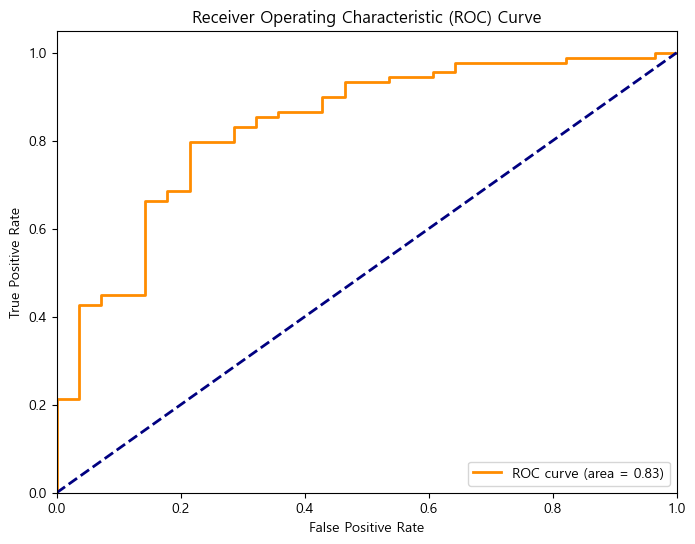

In [41]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_curve, auc, RocCurveDisplay
)
import matplotlib.pyplot as plt

# 예시 데이터 (X_train, X_test, y_train, y_test가 있다고 가정)
# model 생성 및 학습
model = LogisticRegression()
model.fit(X_train_sd_resampled, y_train_sd_resampled)

# 예측 및 평가 지표 계산
y_pred = model.predict(X_test_sd)
y_pred_proba = model.predict_proba(X_test_sd)[:, 1]  # 클래스 1에 대한 확률

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# ROC 커브 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC 커브 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [42]:
df2 = pd.DataFrame()

In [43]:
logit = LogisticRegression()
logit.fit(X_train_sd_resampled, y_train_sd_resampled)
y_pred_train = logit.predict(X_train_sd_resampled)
y_pred_test = logit.predict(X_test_sd)

log_train = [accuracy_score(y_train_sd_resampled, y_pred_train),precision_score(y_train_sd_resampled, y_pred_train),recall_score(y_train_sd_resampled, y_pred_train),f1_score(y_train_sd_resampled, y_pred_train),roc_auc_score(y_train_sd_resampled, y_pred_train)]
log_test = [accuracy_score(y_test, y_pred_test),precision_score(y_test, y_pred_test),recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test),roc_auc_score(y_test, y_pred_test)]

df2['logit_train'] = log_train
df2['logit_test'] = log_test

print(confusion_matrix(y_test,y_pred_test))

[[16 12]
 [11 78]]


In [44]:
df2.index = ['accuracy','precision','recall','f1-score','roc-auc']
df2

,logit_train,logit_test
accuracy,0.852217,0.803419
precision,0.862944,0.866667
recall,0.837438,0.876404
f1-score,0.850000,0.871508
roc-auc,0.852217,0.723917


### (2) mm

Accuracy: 0.7008547008547008
Precision: 0.8375
Recall: 0.7528089887640449
F1 Score: 0.7928994082840237


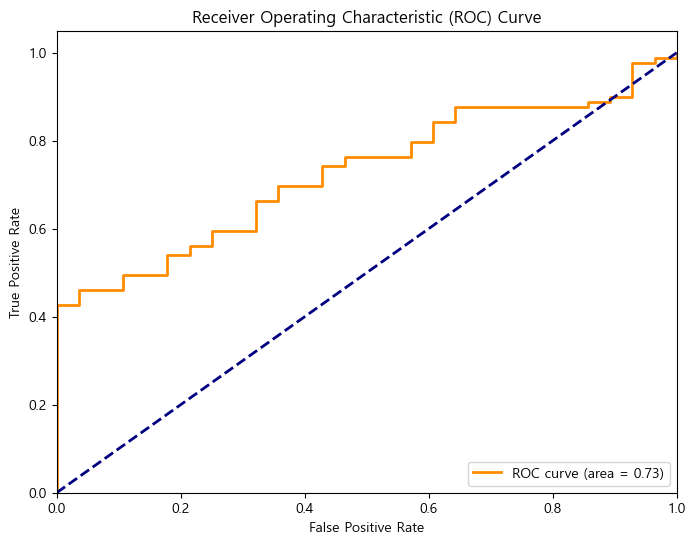

In [45]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_curve, auc, RocCurveDisplay
)
import matplotlib.pyplot as plt

# 예시 데이터 (X_train, X_test, y_train, y_test가 있다고 가정)
# model 생성 및 학습
model = LogisticRegression()
model.fit(X_train_mm_resampled, y_train_mm_resampled)

# 예측 및 평가 지표 계산
y_pred = model.predict(X_test_mm)
y_pred_proba = model.predict_proba(X_test_mm)[:, 1]  # 클래스 1에 대한 확률

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# ROC 커브 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC 커브 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [46]:
df3 = pd.DataFrame()

In [47]:
logit = LogisticRegression()
logit.fit(X_train_mm_resampled, y_train_mm_resampled)
y_pred_train = logit.predict(X_train_mm_resampled)
y_pred_test = logit.predict(X_test_mm)

log_train = [accuracy_score(y_train_mm_resampled, y_pred_train),precision_score(y_train_mm_resampled, y_pred_train),recall_score(y_train_mm_resampled, y_pred_train),f1_score(y_train_mm_resampled, y_pred_train),roc_auc_score(y_train_mm_resampled, y_pred_train)]
log_test = [accuracy_score(y_test, y_pred_test),precision_score(y_test, y_pred_test),recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test),roc_auc_score(y_test, y_pred_test)]

df3['logit_train'] = log_train
df3['logit_test'] = log_test

print(confusion_matrix(y_test,y_pred_test))

[[15 13]
 [22 67]]


In [48]:
df3.index = ['accuracy','precision','recall','f1-score','roc-auc']
df3

,logit_train,logit_test
accuracy,0.742647,0.700855
precision,0.741463,0.837500
recall,0.745098,0.752809
f1-score,0.743276,0.792899
roc-auc,0.742647,0.644262


### (3) rb

Accuracy: 0.5042735042735043
Precision: 0.7313432835820896
Recall: 0.550561797752809
F1 Score: 0.6282051282051283


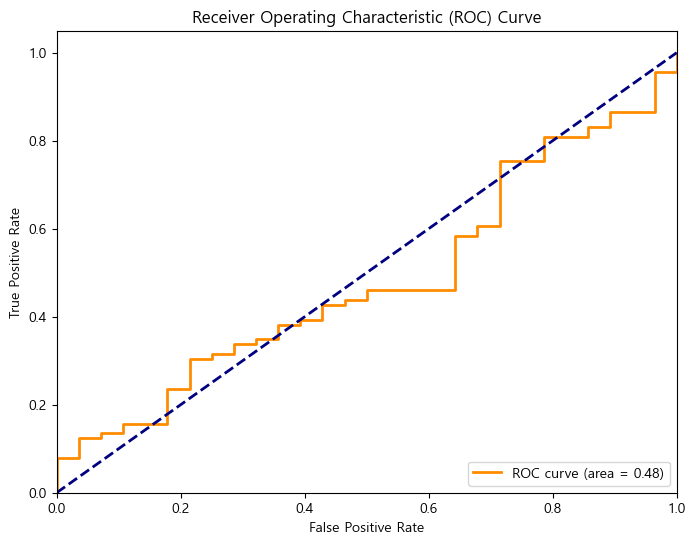

In [49]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_curve, auc, RocCurveDisplay
)
import matplotlib.pyplot as plt

# 예시 데이터 (X_train, X_test, y_train, y_test가 있다고 가정)
# model 생성 및 학습
model = LogisticRegression()
model.fit(X_train_rb_resampled, y_train_rb_resampled)

# 예측 및 평가 지표 계산
y_pred = model.predict(X_test_rb)
y_pred_proba = model.predict_proba(X_test_rb)[:, 1]  # 클래스 1에 대한 확률

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# ROC 커브 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# ROC 커브 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [50]:
df4 = pd.DataFrame()

In [51]:
logit = LogisticRegression()
logit.fit(X_train_rb_resampled, y_train_rb_resampled)
y_pred_train = logit.predict(X_train_rb_resampled)
y_pred_test = logit.predict(X_test_rb)

log_train = [accuracy_score(y_train_rb_resampled, y_pred_train),precision_score(y_train_rb_resampled, y_pred_train),recall_score(y_train_rb_resampled, y_pred_train),f1_score(y_train_rb_resampled, y_pred_train),roc_auc_score(y_train_rb_resampled, y_pred_train)]
log_test = [accuracy_score(y_test, y_pred_test),precision_score(y_test, y_pred_test),recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test),roc_auc_score(y_test, y_pred_test)]

df4['logit_train'] = log_train
df4['logit_test'] = log_test

print(confusion_matrix(y_test,y_pred_test))

[[10 18]
 [40 49]]


In [52]:
df4.index = ['accuracy','precision','recall','f1-score','roc-auc']
df4

,logit_train,logit_test
accuracy,0.593137,0.504274
precision,0.594059,0.731343
recall,0.588235,0.550562
f1-score,0.591133,0.628205
roc-auc,0.593137,0.453852


In [54]:
display(df2, df3, df4)

,logit_train,logit_test
accuracy,0.852217,0.803419
precision,0.862944,0.866667
recall,0.837438,0.876404
f1-score,0.850000,0.871508
roc-auc,0.852217,0.723917


,logit_train,logit_test
accuracy,0.742647,0.700855
precision,0.741463,0.837500
recall,0.745098,0.752809
f1-score,0.743276,0.792899
roc-auc,0.742647,0.644262


,logit_train,logit_test
accuracy,0.593137,0.504274
precision,0.594059,0.731343
recall,0.588235,0.550562
f1-score,0.591133,0.628205
roc-auc,0.593137,0.453852
